In [2]:
import pandas as pd
dataset="MSFT.csv"

df = pd.read_csv(dataset)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9625,2024-05-22,430.089996,432.410004,427.130005,430.519989,430.519989,18073700
9626,2024-05-23,432.970001,433.600006,425.420013,427.000000,427.000000,17211700
9627,2024-05-24,427.190002,431.059998,424.410004,430.160004,430.160004,11845800
9628,2024-05-28,429.630005,430.820007,426.600006,430.320007,430.320007,15706000


# Import Libraries

In [42]:
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9630.000000,9630.000000,9630.000000,9630.000000,9630.000000,9.630000e+03
mean,56.732557,57.321285,56.130464,56.747588,51.119855,5.693863e+07
std,86.686061,87.505350,85.824408,86.709196,86.685667,3.814265e+07
min,0.088542,0.092014,0.088542,0.090278,0.055765,2.304000e+06
25%,5.666016,5.728516,5.578125,5.656250,3.493895,3.227405e+07
50%,27.280001,27.535626,27.040001,27.293438,19.145755,5.006600e+07
75%,46.373750,46.887500,45.833125,46.355938,37.760951,7.092580e+07
max,432.970001,433.600006,427.160004,430.519989,430.519989,1.031789e+09


In [6]:
# Missing values for every column
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [22]:
df = df[['Date', 'Close']]


In [23]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [24]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\neil6\AppData\Local\Temp\ipykernel_19376\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9625   2024-05-22
9626   2024-05-23
9627   2024-05-24
9628   2024-05-28
9629   2024-05-29
Name: Date, Length: 9630, dtype: datetime64[ns]

In [25]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-05-22,430.519989
2024-05-23,427.000000
2024-05-24,430.160004


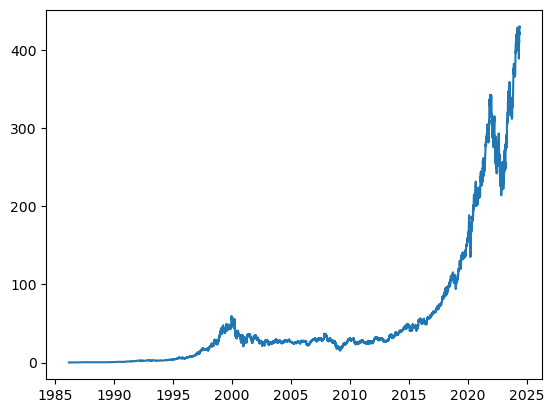

In [26]:
plt.plot(df.index, df['Close'])

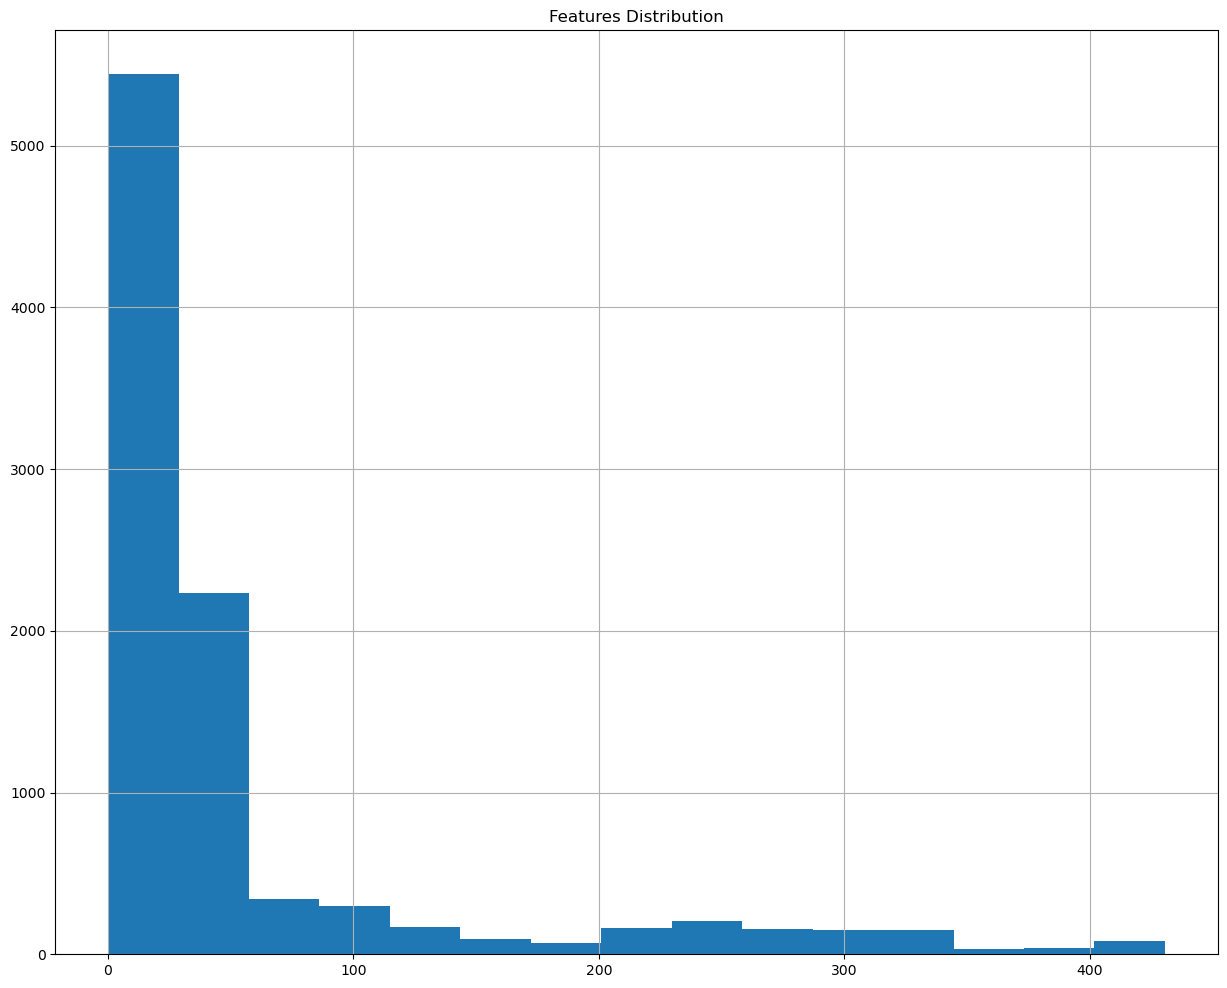

In [27]:
df.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

In [29]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [30]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

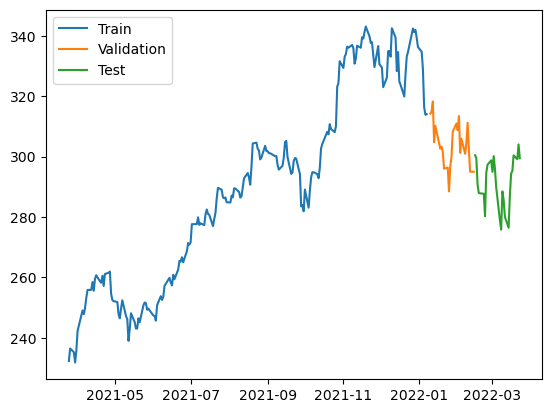

In [31]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#  Model Building

In [32]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 85524.9375 - mean_absolute_error: 290.6906 - val_loss: 92260.8984 - val_mean_absolute_error: 303.6576
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 83150.1875 - mean_absolute_error: 286.7422 - val_loss: 92097.5938 - val_mean_absolute_error: 303.3885
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 84026.0938 - mean_absolute_error: 288.1395 - val_loss: 91876.9297 - val_mean_absolute_error: 303.0247
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 84147.2344 - mean_absolute_error: 288.3469 - val_loss: 91523.0234 - val_mean_absolute_error: 302.4401
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 83571.6484 - mean_absolute_error: 287.3776 - val_loss: 91065.9922 - val_mean_absolute_error: 301.6836
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 81828.6016 - mean_absolute_error: 284.3232 - val_loss: 90436.9688 - val_mean_absolute_error: 300.6393
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 927.9307 - mean_absolute_error: 25.5715 - val_loss: 248.4088 - val_mean_absolute_error: 14.1431
Epoch 44/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 943.8217 - mean_absolute_error: 25.7010 - val_loss: 263.1697 - val_mean_absolute_error: 14.6227
Epoch 45/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 977.1667 - mean_absolute_error: 26.5779 - val_loss: 237.2885 - val_mean_absolute_error: 13.7790
Epoch 46/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 996.6237 - mean_absolute_error: 26.9112 - val_loss: 265.6310 - val_mean_absolute_error: 14.7062
Epoch 47/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 911.4886 - mean_absolute_error: 25.3631 - val_loss: 242.6967 - val_mean_absolute_error: 13.9679
Epoch 48/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1015.4083 - mean_absolute_error: 27.4250 - val_loss: 268.1233 - val_mean_absolute_error: 14.7908
Epoch 49/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 981.4518 - mean_absolut

Epoch 87/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.6059 - mean_absolute_error: 4.0595 - val_loss: 39.6235 - val_mean_absolute_error: 4.9965
Epoch 88/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 22.9035 - mean_absolute_error: 3.6297 - val_loss: 45.2264 - val_mean_absolute_error: 5.3474
Epoch 89/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.8428 - mean_absolute_error: 3.6386 - val_loss: 32.7969 - val_mean_absolute_error: 4.7866
Epoch 90/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26.1388 - mean_absolute_error: 3.9059 - val_loss: 50.5686 - val_mean_absolute_error: 5.6451
Epoch 91/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23.1824 - mean_absolute_error: 3.9744 - val_loss: 60.5786 - val_mean_absolute_error: 6.1064
Epoch 92/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 26.5953 - mean_absolute_error: 4.0804 - val_loss: 69.2401 - val_mean_absolute_error: 6.6260
Epoch 93/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24.6341 - mean_absolute_error: 4.06

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


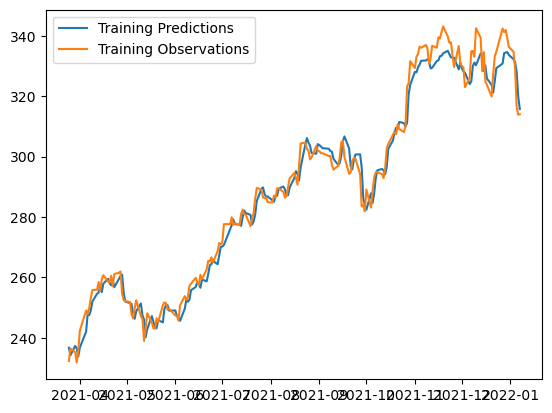

In [33]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


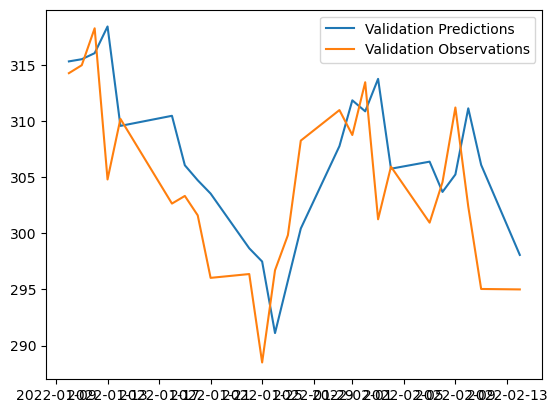

In [34]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


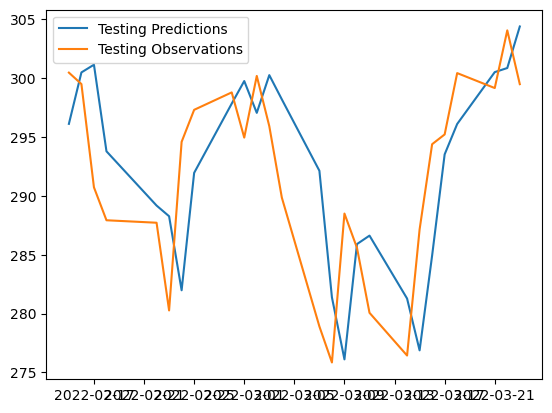

In [35]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

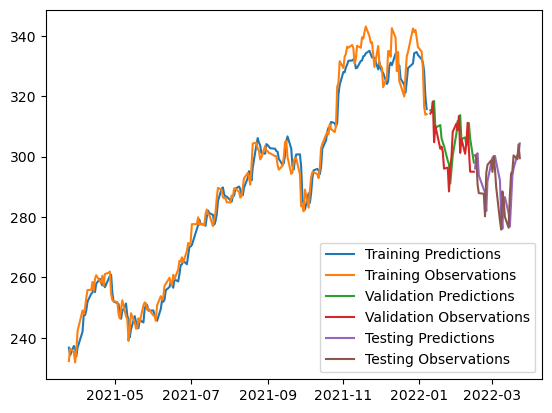

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Saving the model

In [44]:
save_model(model, 'stockforecasting.keras')

In [45]:
loaded_model = load_model('stockforecasting.keras')

C:\Users\neil6\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


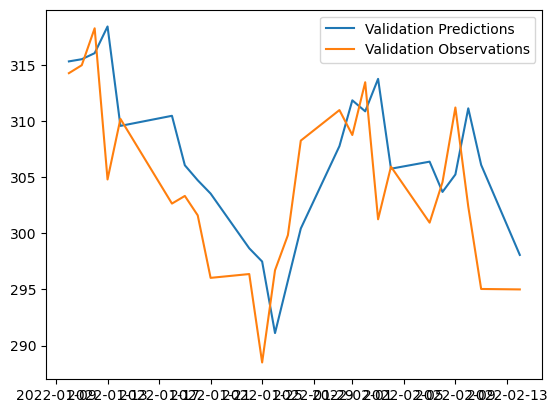

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


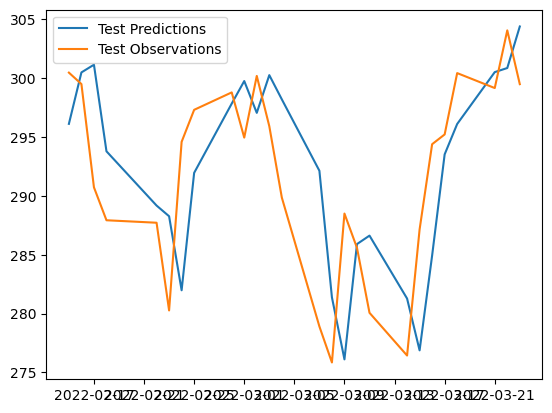

In [46]:

val_predictions =loaded_model.predict(X_val).flatten()


plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()


test_predictions =loaded_model.predict(X_test).flatten()


plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])
plt.show()


In [48]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
from PIL import Image, ImageTk
import numpy as np
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Mocked functions for illustration purposes
def mock_load_model():
    model = Sequential([
        layers.Input((3, 1)),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    return model

def predict(model, X):
    # Make predictions
    predictions = model.predict(X).flatten()
    return predictions

def load_data():
    # Mocked data
    X = np.random.rand(10, 3, 1)  # Mocked input data
    return X

def load_model():
    # Load your pre-trained model here
    model = mock_load_model()  # For illustration, using mocked model
    return model

def on_predict():
    global model, entry_date1, entry_date2, label_result

    # Get the input dates
    date_str1 = entry_date1.get()
    date_str2 = entry_date2.get()

    # Convert string dates to datetime objects
    date1 = datetime.datetime.strptime(date_str1, '%Y-%m-%d')
    date2 = datetime.datetime.strptime(date_str2, '%Y-%m-%d')

    # Load data and preprocess
    X = load_data()

    # Predict
    predictions = predict(model, X)

    # Display result
    result_str = "Predictions:\n"
    for i, pred in enumerate(predictions):
        result_str += f"Prediction {i+1}: {pred}\n"

    label_result.config(text=result_str)

# Create the main window
root = tk.Tk()
root.title("Stock Price Prediction")

# Load model
model = load_model()

# Date entry fields
label_date1 = tk.Label(root, text="Enter Start Date (YYYY-MM-DD):")
label_date1.pack()
entry_date1 = tk.Entry(root)
entry_date1.pack()

label_date2 = tk.Label(root, text="Enter End Date (YYYY-MM-DD):")
label_date2.pack()
entry_date2 = tk.Entry(root)
entry_date2.pack()

# Predict button
predict_button = tk.Button(root, text="Predict", command=on_predict)
predict_button.pack()

# Result label
label_result = tk.Label(root, text="")
label_result.pack()

# Run the Tkinter event loop
root.mainloop()


In [58]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
from tkcalendar import Calendar
import numpy as np
import datetime
from tensorflow.keras.models import load_model

# Function to load the MSFT dataset
import pandas as pd

def load_data():
    try:
        # Load the MSFT dataset from a CSV file
        # Replace 'path_to_msft_data.csv' with the actual path to your dataset file
        df = pd.read_csv(dataset)

        # Assuming the dataset contains 'Close' prices
        close_prices = df['Close'].values

        # Reshape the data to match the input shape of the model
        X = np.reshape(close_prices, (-1, 3, 1))

        return X
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load data: {e}")
        return None


# Function to predict stock prices using the loaded model
def predict(model, X):
    # Make predictions
    predictions = model.predict(X).flatten()
    return predictions

# Function to handle predict button click event
def on_predict():
    global model, calendar_start, calendar_end, label_result

    # Get selected dates
    date_start = calendar_start.get_date()
    date_end = calendar_end.get_date()

    # Convert selected dates to datetime objects
    start_date = datetime.datetime.strptime(date_start, '%m/%d/%y')
    end_date = datetime.datetime.strptime(date_end, '%m/%d/%y')

    # Load data and preprocess
    X = load_data()

    # Predict
    predictions = predict(model, X)

    # Display result
    result_str = "Predictions:\n"
    for i, pred in enumerate(predictions):
        result_str += f"Prediction {i+1}: {pred}\n"

    label_result.config(text=result_str)

# Function to load the pre-trained stockforecasting model
def load_stockforecasting_model():
    try:
        # Load the pre-trained model named "stockforecasting.keras"
        model = load_model('stockforecasting.keras')
        return model
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return None

# Create the main window
root = tk.Tk()
root.title("Stock Price Prediction")

# Load the stockforecasting model
model = load_stockforecasting_model()

# Calendar for selecting start date
label_start = tk.Label(root, text="Select Start Date:")
label_start.pack()
calendar_start = Calendar(root, selectmode="day", date_pattern="mm/dd/yy")
calendar_start.pack()

# Calendar for selecting end date
label_end = tk.Label(root, text="Select End Date:")
label_end.pack()
calendar_end = Calendar(root, selectmode="day", date_pattern="mm/dd/yy")
calendar_end.pack()

# Predict button
predict_button = tk.Button(root, text="Predict", command=on_predict)
predict_button.pack()

# Result label
label_result = tk.Label(root, text="")
label_result.pack()

# Run the Tkinter event loop
root.mainloop()


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
!pip install tkcalendar

: 